# Markdown Chunking for RAG System

This notebook implements text chunking specifically optimized for Markdown content. It uses LangChain's `MarkdownTextSplitter` to create semantically coherent chunks that preserve the structure of markdown documents.

In [1]:
# Import required libraries
import os
import json
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import re

# Import LangChain's Markdown text splitter
from langchain_text_splitters import MarkdownTextSplitter

# For visualization
import matplotlib.pyplot as plt

## Parse Markdown Frontmatter

First, we'll create a function to extract metadata from markdown frontmatter without external dependencies.

In [2]:
def parse_frontmatter(content):
    """
    Parse markdown frontmatter without external dependencies.
    
    Args:
        content (str): Markdown content with YAML frontmatter
        
    Returns:
        tuple: (metadata_dict, content_without_frontmatter)
    """
    if not content.startswith('---'):
        return {}, content
    
    # Find the end of the frontmatter section
    parts = content.split('---', 2)
    if len(parts) < 3:
        return {}, content
    
    frontmatter_text = parts[1].strip()
    content_text = parts[2].strip()
    
    # Parse YAML manually
    metadata = {}
    for line in frontmatter_text.split('\n'):
        line = line.strip()
        if not line or ':' not in line:
            continue
        
        # Split at the first colon
        key, value = line.split(':', 1)
        key = key.strip()
        value = value.strip()
        
        # Remove quotes if present
        if value.startswith('"') and value.endswith('"'):
            value = value[1:-1]
        elif value.startswith("'") and value.endswith("'"):
            value = value[1:-1]
            
        metadata[key] = value
    
    return metadata, content_text

## Configure Markdown Text Splitter

Now we'll set up a specialized Markdown text splitter that understands Markdown structure and semantics.

In [3]:
def create_markdown_splitter(chunk_size=500, chunk_overlap=50):
    """
    Create a MarkdownTextSplitter with the specified parameters.
    
    Args:
        chunk_size (int): Maximum size of each text chunk (in characters)
        chunk_overlap (int): Number of characters to overlap between chunks
        
    Returns:
        MarkdownTextSplitter: Configured markdown text splitter
    """
    # Create a markdown text splitter
    # This automatically uses appropriate separators for markdown structure
    markdown_splitter = MarkdownTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    return markdown_splitter

## Process Markdown Files

Now we'll create a function to process markdown files, extract metadata, and split the content into chunks.

In [4]:
def split_markdown_file(file_path, markdown_splitter):
    """
    Split a markdown file into chunks while preserving metadata and markdown structure.
    
    Args:
        file_path (str or Path): Path to the markdown file
        markdown_splitter (MarkdownTextSplitter): Configured markdown splitter
        
    Returns:
        list: List of dictionaries, each with 'content' and 'metadata' keys
    """
    # Read the markdown file
    file_path = Path(file_path)  # Ensure it's a Path object
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Parse frontmatter and content
    metadata, text_content = parse_frontmatter(content)
    
    # Add source information to metadata
    metadata['source_file'] = str(file_path)
    metadata['filename'] = file_path.name
    
    # Extract heading if present (for better context)
    main_heading = ""
    heading_match = re.search(r'^\s*#\s+(.+)$', text_content, re.MULTILINE)
    if heading_match:
        main_heading = heading_match.group(1).strip()
        metadata['heading'] = main_heading
    
    # Split the content into chunks
    chunks = markdown_splitter.split_text(text_content)
    
    # Create a list of dictionaries with chunks and metadata
    result = []
    for i, chunk_text in enumerate(chunks):
        # Create a copy of the metadata for each chunk
        chunk_metadata = metadata.copy()
        
        # Add chunk-specific metadata
        chunk_metadata['chunk_id'] = i
        chunk_metadata['chunk_count'] = len(chunks)
        
        # Try to extract heading from this chunk if not already found
        if not main_heading:
            heading_match = re.search(r'^\s*#\s+(.+)$', chunk_text, re.MULTILINE)
            if heading_match:
                chunk_metadata['chunk_heading'] = heading_match.group(1).strip()
        
        # Create a document dictionary
        document = {
            'content': chunk_text.strip(),
            'metadata': chunk_metadata
        }
        
        result.append(document)
    
    return result

## Demonstration with Sample Text

Let's test our chunking approach with a sample markdown document.

In [5]:
# Sample markdown text with frontmatter
sample_text = """---
title: MS in Applied Data Science – Course Progressions
original_url: https://datascience.uchicago.edu/education/masters-programs/ms-in-applied-data-science/course-progressions
category: education
date: 2025-05-04
---

# Course Progressions

## Full-Time Study

Full-time students typically complete the degree in 12 months, taking 3 courses per quarter for 4 quarters (9 core courses, 3 electives).

**Quarter 1** • 10 Weeks

* **Programming for Analytics** - An introduction to programming in Python, with emphasis on applications to data analysis.
* **Statistical Analysis** - Covers fundamental statistical methods for data analysis.
* **Linear Algebra & Matrix Analysis** - Provides the mathematical foundation for many techniques in data science.

**Quarter 2** • 10 Weeks

* **Machine Learning** - Introduction to core machine learning algorithms and concepts.
* **Data Engineering** - Techniques for collecting, storing, and accessing data for analysis.
* **Elective 1** - Students select from available electives based on their interests.

## Part-Time Study

Part-time students typically complete the degree in 18-24 months, taking 1-2 courses per quarter.

**Year 1, Quarter 1** • 10 Weeks

* **Programming for Analytics** - An introduction to programming in Python.
* **Statistical Analysis** - Covers fundamental statistical methods.
"""

# Save sample text to a temporary file
sample_file_path = "../data/sample_markdown.md"
with open(sample_file_path, "w", encoding="utf-8") as f:
    f.write(sample_text)

# Create markdown splitter
markdown_splitter = create_markdown_splitter(chunk_size=500, chunk_overlap=50)

# Split the sample text
sample_chunks = split_markdown_file(sample_file_path, markdown_splitter)

# Display the chunks
print(f"Split into {len(sample_chunks)} chunks:\n")
for i, chunk in enumerate(sample_chunks):
    print(f"Chunk {i+1} (Length: {len(chunk['content'])} chars)")
    print("-" * 80)
    print(chunk['content'])
    print("-" * 80)
    print(f"Metadata: {json.dumps(chunk['metadata'], indent=2)}")
    print("\n" + "=" * 80 + "\n")

Split into 4 chunks:

Chunk 1 (Length: 206 chars)
--------------------------------------------------------------------------------
# Course Progressions

## Full-Time Study

Full-time students typically complete the degree in 12 months, taking 3 courses per quarter for 4 quarters (9 core courses, 3 electives).

**Quarter 1** • 10 Weeks
--------------------------------------------------------------------------------
Metadata: {
  "title": "MS in Applied Data Science \u2013 Course Progressions",
  "original_url": "https://datascience.uchicago.edu/education/masters-programs/ms-in-applied-data-science/course-progressions",
  "category": "education",
  "date": "2025-05-04",
  "source_file": "..\\data\\sample_markdown.md",
  "filename": "sample_markdown.md",
  "heading": "Course Progressions",
  "chunk_id": 0,
  "chunk_count": 4
}


Chunk 2 (Length: 377 chars)
--------------------------------------------------------------------------------
**Quarter 1** • 10 Weeks

* **Programming for Analyt

## Process Directory of Markdown Files

Now let's process a directory of cleaned markdown files and save the chunks to JSON files.

In [6]:
def process_markdown_directory(input_dir, output_dir, chunk_size=500, chunk_overlap=50):
    """
    Process all markdown files in a directory, chunk them, and save to individual JSON files.
    
    Args:
        input_dir (str): Directory containing markdown files
        output_dir (str): Directory to save the chunk files
        chunk_size (int): Maximum size of each text chunk
        chunk_overlap (int): Number of characters to overlap between chunks
    
    Returns:
        tuple: (total_files_processed, total_chunks_created)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create markdown splitter
    markdown_splitter = create_markdown_splitter(chunk_size, chunk_overlap)
    
    # Find all markdown files
    input_path = Path(input_dir)
    markdown_files = list(input_path.glob("*.md"))
    print(f"Found {len(markdown_files)} markdown files in {input_dir}")
    
    # Process each file
    all_chunks = []
    file_count = 0
    chunk_count = 0
    
    for md_file in tqdm(markdown_files, desc="Processing files"):
        try:
            # Process the file
            file_chunks = split_markdown_file(md_file, markdown_splitter)
            
            if file_chunks:
                # Add to total counts
                file_count += 1
                chunk_count += len(file_chunks)
                all_chunks.extend(file_chunks)
                
                # Save individual file chunks
                output_file = os.path.join(output_dir, f"{md_file.stem}_chunks.json")
                with open(output_file, "w", encoding="utf-8") as f:
                    json.dump(file_chunks, f, indent=2)
        except Exception as e:
            print(f"Error processing {md_file}: {str(e)}")
    
    # Save all chunks to a single JSON file
    all_chunks_file = os.path.join(output_dir, "all_chunks.json")
    with open(all_chunks_file, "w", encoding="utf-8") as f:
        json.dump(all_chunks, f)
    
    print(f"Processed {file_count} files and created {chunk_count} chunks")
    print(f"Saved all chunks to {all_chunks_file}")
    
    return file_count, chunk_count

In [7]:
# Process the cleaned markdown directory
input_dir = "../data/markdown_clean"  # Directory with cleaned markdown files
output_dir = "../data/chunks"        # Directory to save chunk files

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process all markdown files and create chunks
files_processed, chunks_created = process_markdown_directory(
    input_dir=input_dir,
    output_dir=output_dir,
    chunk_size=500,
    chunk_overlap=50
)

Found 4 markdown files in ../data/markdown_clean


Processing files:   0%|          | 0/4 [00:00<?, ?it/s]

Processed 4 files and created 389 chunks
Saved all chunks to ../data/chunks\all_chunks.json


## Analyze Chunk Distribution

Let's analyze the distribution of chunks to ensure our chunking strategy is effective.

In [8]:
def analyze_chunks(all_chunks_file):
    """
    Analyze the distribution of chunks and their metadata.
    
    Args:
        all_chunks_file (str): Path to the JSON file with all chunks
    """
    # Load the chunks
    with open(all_chunks_file, "r", encoding="utf-8") as f:
        chunks = json.load(f)
    
    # Calculate chunk lengths
    chunk_lengths = [len(chunk["content"]) for chunk in chunks]
    
    # Extract categories
    categories = [chunk["metadata"].get("category", "unknown") for chunk in chunks]
    
    # Create a DataFrame for analysis
    df = pd.DataFrame({
        "length": chunk_lengths,
        "category": categories
    })
    
    # Display basic statistics
    print(f"Total chunks: {len(chunks)}")
    print(f"Average chunk length: {df['length'].mean():.2f} characters")
    print(f"Min chunk length: {df['length'].min()} characters")
    print(f"Max chunk length: {df['length'].max()} characters")
    
    # Display category distribution
    category_counts = df["category"].value_counts()
    print("\nCategory distribution:")
    print(category_counts)
    
    # Plot distribution of chunk lengths
    plt.figure(figsize=(10, 6))
    plt.hist(chunk_lengths, bins=30)
    plt.xlabel("Chunk Length (characters)")
    plt.ylabel("Count")
    plt.title("Distribution of Chunk Lengths")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot category distribution
    plt.figure(figsize=(12, 6))
    category_counts.plot(kind="bar")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.title("Chunks by Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df

Total chunks: 389
Average chunk length: 340.52 characters
Min chunk length: 12 characters
Max chunk length: 499 characters

Category distribution:
category
education    389
Name: count, dtype: int64


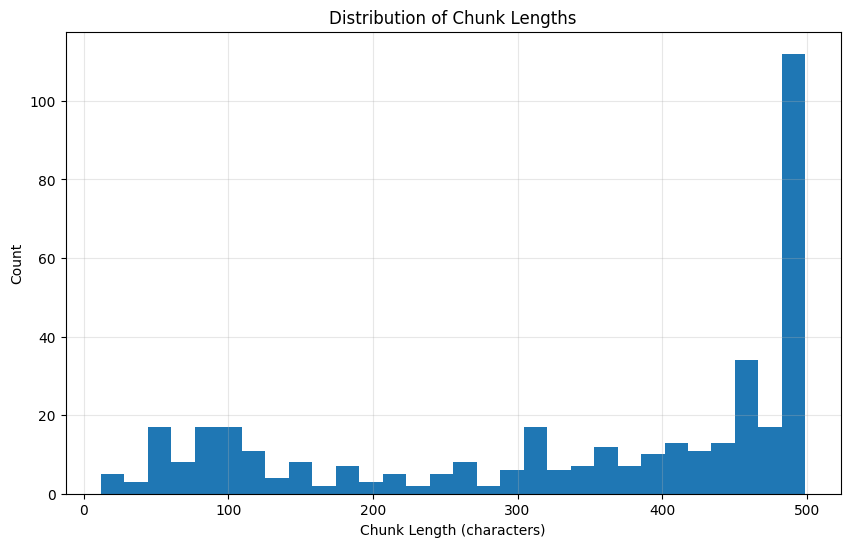

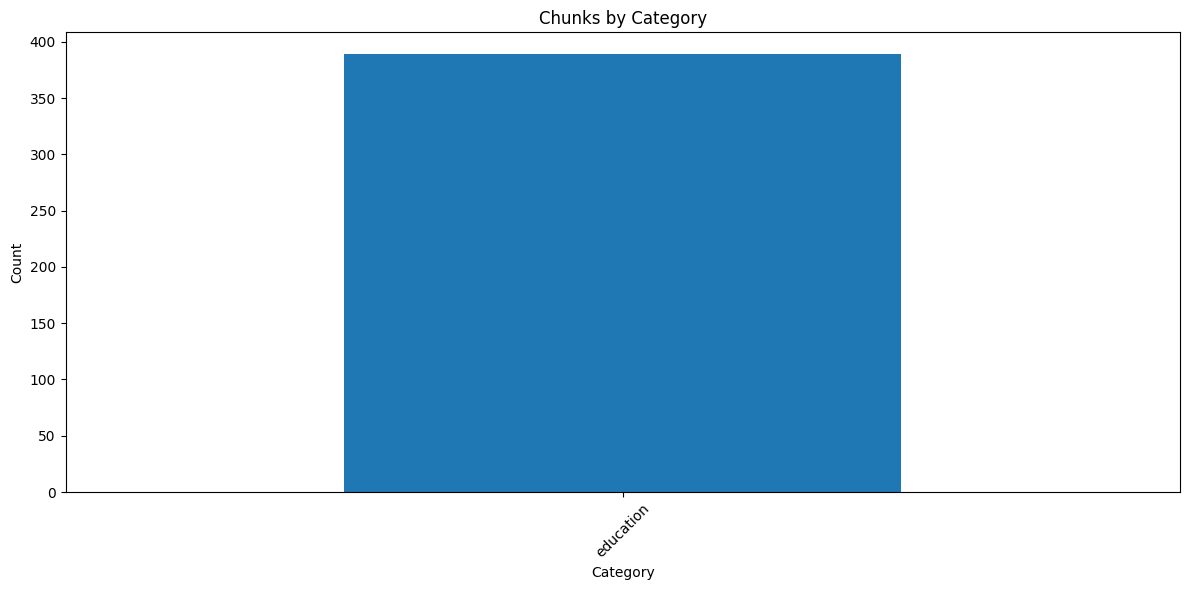

In [9]:
# Analyze the chunk distribution
chunk_stats = analyze_chunks(os.path.join(output_dir, "all_chunks.json"))